##### This tutorial is refer to https://jaketae.github.io/study/word2vec/

In [1]:
import numpy as np
import string
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn')

np.random.seed(1011)
np.set_printoptions(suppress=True)

In [2]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

In [3]:
def tokenize(input_string):
    '''
    Tokenize the training data. Punctuation is removed and 
    each words in the training data is split as a elements in a list.
    '''
    tokens = ''.join([char 
                        for char in input_string.lower() 
                        if char not in string.punctuation])
    return tokens.split(' ')

def text_dictionary(tokens):
    '''
    Create two dictionary named word_to_idx and idx_to_word.
    In word_to_idx each word is as key with a assigned unique id as value.
    idx_to_word is same as word_to_idx except that id is as key and word as value
    '''
    word_to_idx = {}
    idx_to_word = {}

    # turn the tokens into set before looping to remove duplicate words
    for i, token in enumerate(set(tokens)):
        word_to_idx[token] = i
        idx_to_word[i] = token

    return word_to_idx, idx_to_word

def concat(*iterables):
    for iterable in iterables:
        yield from iterable

def one_hot_encode(id, vocab_size):
    '''
    Transform a word into one-hot representation
    '''
    # A list with the same length as vocab_size is initialize with all zeros elements
    # except value of the corresponding index of word is 1
    res = [0] * vocab_size
    res[id] = 1
    return res

def generate_training_data(tokens, word_to_idx, window):
    '''
    Generate x, y dataset for our skip-gram model.
    x and y are both the one-hot representation of words.
    '''
    x, y = [], []
    n_tokens = len(tokens)

    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i),
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            x.append(one_hot_encode(word_to_idx[tokens[i]], len(word_to_idx)))
            y.append(one_hot_encode(word_to_idx[tokens[j]], len(word_to_idx)))

    return np.asarray(x), np.asarray(y)

In [4]:
tokens = tokenize(text)
word_to_idx, idx_to_word = text_dictionary(tokens)
x, y = generate_training_data(tokens, word_to_idx, 2)

x.shape, y.shape

((330, 60), (330, 60))

Forward:

&nbsp;&nbsp;&nbsp;&nbsp; $A_1 = X W_1$ <br>
&nbsp;&nbsp;&nbsp;&nbsp; $A_2 = A_1 W_2$ <br>
&nbsp;&nbsp;&nbsp;&nbsp; $Z = Softmax(A_2)$

Backward: 
##### &nbsp;&nbsp;&nbsp;&nbsp; $\frac{dL}{dW_2} = \frac{dL}{dZ} \frac{dZ}{dA_2} \frac{dA_2}{dW_2} = (Z - Y) * A_1$
##### &nbsp;&nbsp;&nbsp;&nbsp; $\frac{dL}{dW_1} = \frac{dL}{dZ} \frac{dZ}{dA_2} \frac{dA_2}{dA_1} \frac{dA_1}{dW_1} = (Z - Y) * W_2 * X$


In [5]:
class SkipGram:

    def __init__(self, vocab_size, n_embedding):
        self.loss_history = []
        self.vocab_size = vocab_size
        self.n_embedding = n_embedding

    def init_weights(self):
        self.w1 = np.random.randn(self.vocab_size, self.n_embedding)
        self.w2 = np.random.randn(self.n_embedding, self.vocab_size)

    def softmax(self, z):
        # minus z by the max of z for number stability
        # keepdims is set to true to unchange the dimensional of array
        exp = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

    def forward(self, x):
        self.a1 = np.dot(x, self.w1)
        self.a2 = np.dot(self.a1, self.w2)
        self.z = self.softmax(self.a2)
        return self.z

    def backward(self, x, y):
        self.da2 = self.z - y
        self.dw2 = np.dot(self.a1.T, self.da2)
        self.da1 = np.dot(self.da2, self.w2.T)
        self.dw1 = np.dot(x.T, self.da1)

    def update(self, lr): # SGD
        self.w1 -= lr * self.dw1
        self.w2 -= lr * self.dw2

    def loss(self, y, m): # cross_entropy
        self.loss_history.append(- np.sum(np.log(self.z) * y) / m)

    def fit(self, x, y, epochs, lr):
        m = x.shape[0]
        self.init_weights()
        for _ in range(epochs):
            self.forward(x)
            self.backward(x, y)
            self.update(lr)
            self.loss(y, m)

    def predict(self, x):
        return self.forward(x)

In [6]:
epochs = 50
lr = 0.05

model = SkipGram(x.shape[1], 10)
model.fit(x, y, epochs, lr)

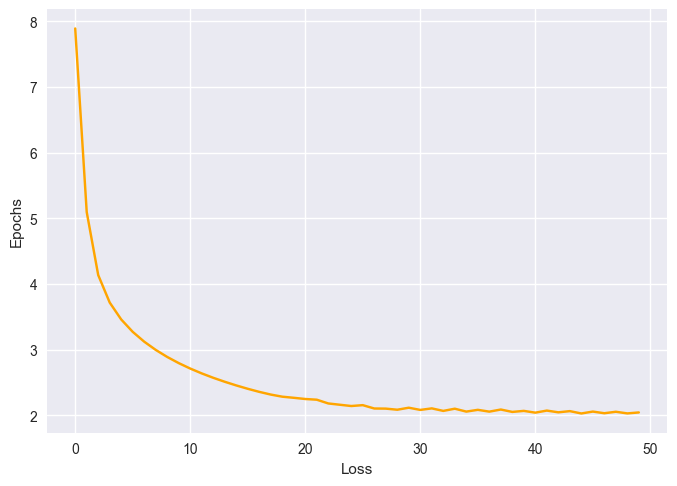

In [7]:
plt.plot(range(epochs), model.loss_history, color='orange')
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.show()

In [8]:
test = one_hot_encode(word_to_idx['machine'], len(word_to_idx))
# the test word is a python list so we need to transform it into a numpy array 
# with shape of 2 dimensional using the expand_dims() function 
test = np.expand_dims(np.array(test), 0)

result = model.predict(test)

probabilities = {
    idx_to_word[idx]: result[0][idx]
    for idx in np.argsort(result[0])[::-1]
}

probabilities

{'learning': 0.480536778330845,
 'algorithms': 0.3377688194815053,
 'is': 0.04542697793625788,
 'intelligence': 0.03825155926886143,
 'do': 0.027287580928447856,
 'so': 0.02282451670957325,
 'artificial': 0.014240955717934366,
 'are': 0.006296404552276763,
 'machine': 0.0037677230997890877,
 'to': 0.0036699805006715205,
 'needed': 0.00292013645507799,
 'programmed': 0.002815890575169761,
 'being': 0.0023342167074187677,
 'of': 0.0015817512750700147,
 'build': 0.001407028567445236,
 'model': 0.0010401574189153229,
 'without': 0.0008175923964334867,
 'the': 0.0007854256240546598,
 'subset': 0.0007465884357408007,
 'explicitly': 0.0006288989419035226,
 'conventional': 0.0005557128246791514,
 'a': 0.0004955721352956547,
 'develop': 0.00045790368374138736,
 'in': 0.00040927299431138775,
 'perform': 0.0003861240205624182,
 'decisions': 0.0003207156488865791,
 'variety': 0.0003037779141912633,
 'make': 0.0002692340875681742,
 'through': 0.00026401451081170264,
 'automatically': 0.000260577001

In [10]:
def get_embedding(word, model):
    word_onehot = one_hot_encode(word_to_idx[word], len(word_to_idx))
    return np.dot(word_onehot, model.w1)


# get the embedding vector or the dense vector of the word 'machine' with 10 dimensional
get_embedding('machine', model)

array([-0.37696774,  0.4015686 , -0.38470064,  0.22110738, -0.40148735,
       -1.35793723, -0.71099678,  1.3348571 ,  1.04877304,  1.91710006])